In [1]:
import os
import sys
import time
from pathlib import Path

import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from PIL import Image

from col_dtypes import ColDataTypes

In [2]:
data_folder = "../../data/" # root data folder
dpi = 50 # spectrogram image resolution

chunk_id = 4 # chunk 1 is noise, chunks 2-6 are earthquake signals
assert chunk_id > 0 and chunk_id <= 6

print(f'Analysing chunk {chunk_id}')

Analysing chunk 4


In [3]:
col_dtypes = ColDataTypes()
dtypes = col_dtypes.get_initial_dtype_dict()
date_cols = col_dtypes.get_date_cols()

csv_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}.csv') # chunk metadata

chunk = pd.read_csv(csv_pth, dtype=dtypes, parse_dates=date_cols, encoding='utf-8')

processed_csv_save_pth = os.path.join(data_folder, f'raw/chunk{chunk_id}/chunk{chunk_id}_processed.csv') # processed metadata save pth
processedChunk = pd.read_csv(processed_csv_save_pth, dtype=dtypes, parse_dates=date_cols, encoding='utf-8')

print(chunk.columns)
print(chunk.shape)
chunk.head()

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')
(200000, 35)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,AZ,CPE,HH,32.8889,-117.1051,150.0,400.0,manual,0.52,17.830000,...,CI,None,0.9927,110.40,100.2,[ 7.19999981 10.60000038 3.70000005],[[3199.]],2012-11-16 01:44:17.540,earthquake_local,CPE.AZ_20121116014416_EV
1,AZ,CPE,HH,32.8889,-117.1051,150.0,500.0,manual,0.60,12.250000,...,CI,None,0.6720,74.73,79.0,[8.5 7.30000019 3.20000005],[[3199.]],2012-11-16 09:37:27.700,earthquake_local,CPE.AZ_20121116093726_EV
2,AZ,CPE,HH,32.8889,-117.1051,150.0,700.0,automatic,0.96,23.530001,...,None,None,1.3120,145.63,84.9,[19.39999962 18.89999962 12.5 ],[[3672.]],2012-11-16 16:33:33.670,earthquake_local,CPE.AZ_20121116163333_EV
3,AZ,CPE,HH,32.8889,-117.1051,150.0,1000.0,automatic,0.00,21.959999,...,None,None,1.2240,135.86,30.6,[24.5 24.79999924 23.70000076],[[3598.]],2012-11-16 19:14:24.390,earthquake_local,CPE.AZ_20121116191424_EV
4,AZ,CPE,HH,32.8889,-117.1051,150.0,400.0,manual,0.59,14.530000,...,CI,None,0.8017,89.16,63.8,[19.5 14.80000019 11.30000019],[[3199.]],2012-11-18 12:04:16.490,earthquake_local,CPE.AZ_20121118120415_EV


# Understanding the Processed Data
Processed Data has been filtered to obtain the P and S-waves

In [4]:
print(processedChunk.columns)
print(processedChunk.shape)
processedChunk.head()

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name', 'same_status?',
       'p_duration', 's_duration'],
      dtype='object')
(81874, 38)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name,same_status?,p_duration,s_duration
0,AZ,CPE,HH,32.8889,-117.1051,150.0,400.0,manual,0.52,17.830000,...,110.40,100.2,[ 7.19999981 10.60000038 3.70000005],3199,2012-11-16 01:44:17.540,earthquake_local,CPE.AZ_20121116014416_EV,True,1299.0,1500.0
1,AZ,CPE,HH,32.8889,-117.1051,150.0,500.0,manual,0.60,12.250000,...,74.73,79.0,[8.5 7.30000019 3.20000005],3199,2012-11-16 09:37:27.700,earthquake_local,CPE.AZ_20121116093726_EV,True,894.0,1805.0
2,AZ,CPE,HH,32.8889,-117.1051,150.0,700.0,automatic,0.96,23.530001,...,145.63,84.9,[19.39999962 18.89999962 12.5 ],3672,2012-11-16 16:33:33.670,earthquake_local,CPE.AZ_20121116163333_EV,True,1720.0,1252.0
3,AZ,CPE,HH,32.8889,-117.1051,150.0,1000.0,automatic,0.00,21.959999,...,135.86,30.6,[24.5 24.79999924 23.70000076],3598,2012-11-16 19:14:24.390,earthquake_local,CPE.AZ_20121116191424_EV,True,1587.0,1011.0
4,AZ,CPE,HH,32.8889,-117.1051,150.0,400.0,manual,0.59,14.530000,...,89.16,63.8,[19.5 14.80000019 11.30000019],3199,2012-11-18 12:04:16.490,earthquake_local,CPE.AZ_20121118120415_EV,True,1032.0,1767.0


In [5]:
processedChunk.dtypes

network_code                                object
receiver_code                               object
receiver_type                               object
receiver_latitude                          float64
receiver_longitude                         float64
receiver_elevation_m                       float64
p_arrival_sample                           float64
p_status                                    object
p_weight                                   float64
p_travel_sec                               float64
s_arrival_sample                           float64
s_status                                    object
s_weight                                   float64
source_id                                   object
source_origin_time                  datetime64[ns]
source_origin_uncertainty_sec               object
source_latitude                            float64
source_longitude                           float64
source_error_sec                            object
source_gap_deg                 

In [6]:
print('Columns with NaN values\n')

for i in processedChunk.columns:
    if processedChunk[i].isnull().values.any() == True:
        print(f'{i}:', True)

Columns with NaN values

p_weight: True
s_weight: True
source_origin_uncertainty_sec: True
source_error_sec: True
source_gap_deg: True


In [7]:
categoricalVar = ['network_code', 'receiver_code', 'receiver_type', 'p_status', 's_status', 'source_id',
                  'source_magnitude_type', 'source_magnitude_author', 'trace_category', 'trace_name',
                  'same_status?']

print('Number of data points:', len(processedChunk))
print('Number of unique datapoints for column\n')

for i in categoricalVar:
    numUnique = len(processedChunk[i].unique())
    result = f'{i}: ' + str(numUnique)
    
    if numUnique <= 23:
        print(result, processedChunk[i].unique())
        
    else: print(result)

Number of data points: 81874
Number of unique datapoints for column

network_code: 69
receiver_code: 460
receiver_type: 6 ['HH' 'BH' 'EH' 'HL' 'SH' 'EL']
p_status: 3 ['manual' 'automatic' 'autopicker']
s_status: 3 ['manual' 'automatic' 'autopicker']
source_id: 60263
source_magnitude_type: 23 ['ml' 'md' 'mb' 'mh' 'mw' 'mlr' 'mb_lg' 'mn' 'm' 'mlv' 'mwr' 'h' 'ms'
 'mww' 'mlg' 'mc' 'mpva' 'mpv' 'mwc' 'mblg' 'mg' 'none' 'mbr']
source_magnitude_author: 13 ['CI' 'None' 'LD' 'SE' 'TUL' 'NN' 'UU' 'NC' 'NM' 'UW' 'HV' 'US' 'ISMP']
trace_category: 1 ['earthquake_local']
trace_name: 81874
same_status?: 2 [ True False]


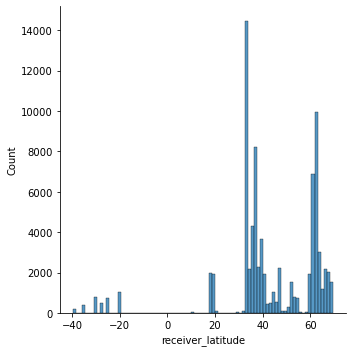

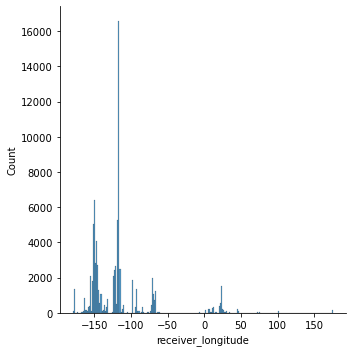

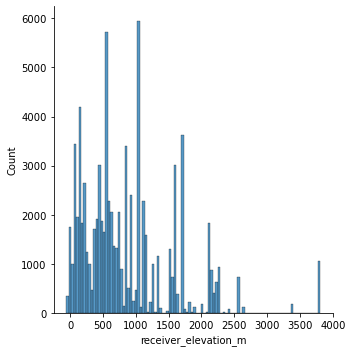

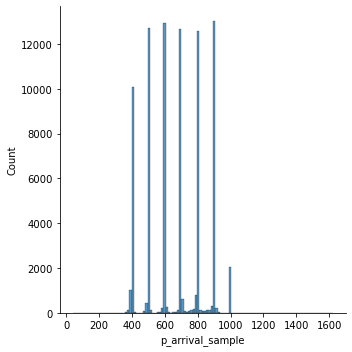

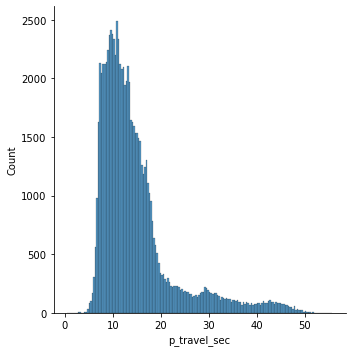

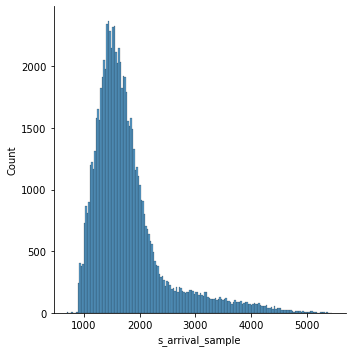

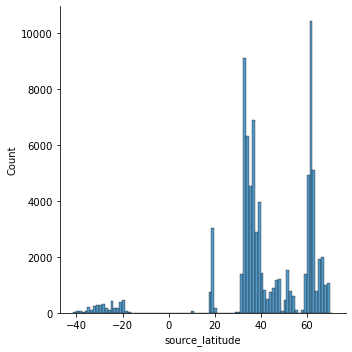

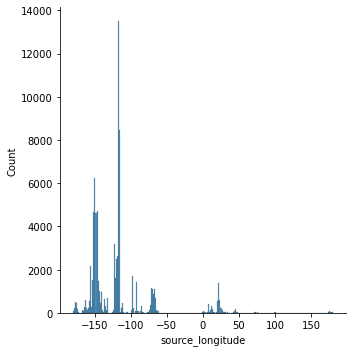

In [8]:
count = 1
limit = 8

for i in processedChunk.columns.tolist():
    if (processedChunk[i].dtypes == 'float64' or processedChunk[i].dtypes == 'object') and processedChunk[i].isnull().values.any() == False and count <= limit and i not in categoricalVar:
        sb.displot(data = processedChunk, x = i)
        count += 1

plt.show()